# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

# Описание услуг

Оператор предоставляет два основных типа услуг: 
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`

* `customerID` — идентификатор абонента;
* `BeginDate` — дата начала действия договора;
* `EndDate` — дата окончания действия договора;
* `Type` — тип оплаты: раз в год-два или ежемесячно;
* `PaperlessBilling` — электронный расчётный лист;
* `PaymentMethod` — тип платежа;
* `MonthlyCharges` — расходы за месяц;
* `TotalCharges` — общие расходы абонента

Файл `personal_new.csv`

* `customerID` — идентификатор пользователя;
* `gender` — пол;
* `SeniorCitizen` — является ли абонент пенсионером;
* `Partner` — есть ли у абонента супруг или супруга;
* `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`

* `customerID` — идентификатор пользователя;
* `InternetService` — тип подключения;
* `OnlineSecurity` — блокировка опасных сайтов;
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
* `DeviceProtection` — антивирус;
* `TechSupport` — выделенная линия технической поддержки;
* `StreamingTV` — стриминговое телевидение;
* `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`

* `customerID` — идентификатор пользователя;
* `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. 
Информация о договорах актуальна на 1 февраля 2020 года.


## Изучение данных

Загрузка библиотек

In [1]:
!pip install phik

In [2]:
#!pip install catboost

In [3]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
RANDOM_STATE = 111223
plt.rcParams["figure.figsize"] = (16,6)
from sklearn.metrics import confusion_matrix

Записываем данные в датафремы:

In [5]:
try:
    df_contract = pd.read_csv('/contract_new.csv')
    df_personal = pd.read_csv('/personal_new.csv')
    df_internet = pd.read_csv('/internet_new.csv')
    df_phone = pd.read_csv('/phone_new.csv')
except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

**Информация о договорах (df_contract)**

In [6]:
#вывод 5 строк
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
#вывод общей информации
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
#проверка дубликатов
df_contract.duplicated().sum()

0

Пропусков и дубликатов в датафрейме нет

**Информация о персональных данных клиентов (df_personal)**

In [9]:
#вывод 5 строк
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
#вывод общей информации
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
#проверка дубликатов
df_personal.duplicated().sum()

0

Пропусков и дубликатов в датафрейме нет

**Информация об интернет-услугах (df_internet)**

In [12]:
#вывод 5 строк
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
#вывод общей информации
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
#проверка дубликатов
df_internet.duplicated().sum()

0

Пропусков и дубликатов в датафрейме нет

**Информация об услугах телефонии (df_phone)**

In [15]:
#вывод 5 строк
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
#вывод общей информации
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
#проверка дубликатов
df_phone.duplicated().sum()

0

Пропусков и дубликатов в датафрейме нет

**Вывод:**

Загружены и изучены данные, которые состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;

- `personal_new.csv` — персональные данные клиента;

- `internet_new.csv` — информация об интернет-услугах;

- `phone_new.csv` — информация об услугах телефонии.

Данные соеденены между собой столбцом "customerID" – уникальный айди клиента.
Пропусков и дубликатов нет.

Определен целевой признак EndDate - длительность пользования клиентом услугами компании. Значение "No" означает, что клиент до сих пор пользуется услугами.

После предобработки данных необходимо объединить все данные в одну таблицу, провести исследовательский анализ данных и дополнительное исследование на наличие пропусков и аномалий, корреляции.

## Предобработка данных

**Кодирование целевого признака**

Добавим целевой признак факт ухода клиента: 0 - не ушел, 1 - ушел.

In [18]:
df_contract['Fact_leave'] = (df_contract['EndDate'] != 'No').astype(int)
#проверка
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


In [19]:
df_contract['Fact_leave'].unique()

array([0, 1])

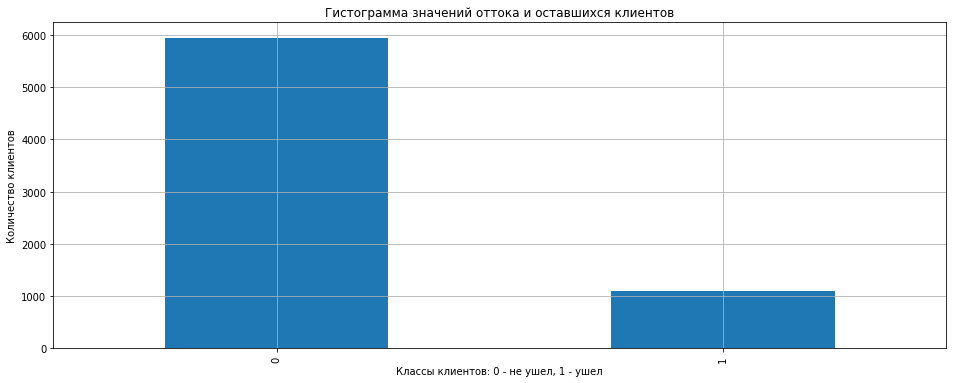

In [20]:
# Гистограмма значений оттока и оставшихся клиентов
df_contract['Fact_leave'].value_counts().plot(kind='bar',grid=True,title='Гистограмма значений оттока и оставшихся клиентов', xlabel = 'Классы клиентов: 0 - не ушел, 1 - ушел',  ylabel = 'Количество клиентов')
plt.show()

**Даты договора**

В EndDate заменим значения "No" на дату 01.02.2020, т.к. известно, что информация о договорах актуальна на 1 февраля 2020. Это позволит определить в дальнейшем срок пользования услугами

In [21]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])
print(df_contract[df_contract['EndDate'] == 'No'].shape[0])
#проверка
df_contract.head(10)

0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


EndDate и BeginDate переведем в формат datetime

In [22]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'],format = '%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'],format = '%Y-%m-%d')

**Неявные пропуски**

При переводе TotalCharges к числовому формату (df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')) возникает ошибка. Возможно есть неявные пропуски. Смотрим значения полей

In [23]:
df_contract['TotalCharges'].value_counts()

          11
20.45      6
101.0      5
732.6      4
19.65      4
          ..
574.43     1
193.4      1
70.8       1
298.5      1
799.5      1
Name: TotalCharges, Length: 6658, dtype: int64

In [24]:
df_contract.query('TotalCharges ==  " "').head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


В столбце `TotalCharges` пропуск отображаются все новые клиенты, которые пользуются услугами только первый месяц, заполним данные пропуски суммой из столбца `MonthlyCharges`

In [25]:
df_contract.loc[df_contract['TotalCharges'] == " ", 'TotalCharges'] = df_contract['MonthlyCharges']

In [26]:
df_contract.query('BeginDate ==  "2020-02-01"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,19.85,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,20.0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,19.7,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,73.35,0


In [27]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace([' '], 0)
df_contract['TotalCharges'].isnull().sum()

0

In [28]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('int')

In [29]:
#проверка изменения
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   int64         
 8   Fact_leave        7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 495.3+ KB


**Объединение таблиц в один датафрейм**

In [30]:
df = df_contract \
    .merge(df_personal, how='left', on='customerID') \
    .merge(df_internet, how='left', on='customerID') \
    .merge(df_phone, how='left', on='customerID') 

In [31]:
#устанавливаем индексом сustomerID
df = df.set_index('customerID')

Изучим объедененную таблицу

In [32]:
df.shape

(7043, 20)

In [33]:
df.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226,0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353,0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150,0,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058,0,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300,0,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573,0,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes


In [34]:
df.describe()

,MonthlyCharges,TotalCharges,Fact_leave,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2114.922902,0.156325,0.162147
std,30.090047,2112.681856,0.363189,0.368612
min,18.250000,19.000000,0.000000,0.000000
25%,35.500000,436.500000,0.000000,0.000000
50%,70.350000,1343.000000,0.000000,0.000000
75%,89.850000,3236.000000,0.000000,0.000000
max,118.750000,9221.000000,1.000000,1.000000


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   int64         
 7   Fact_leave        7043 non-null   int64         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Пропуски в столбцах InternetService,OnlineSecurity, OnlineBackup и др. возможно означают, что эти услуги не подключены. Заменим пропуски на "NotUsed"

In [36]:
df=df.fillna('NotUsed')

In [37]:
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   int64         
 7   Fact_leave        7043 non-null   int64         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

Добавим столбец количество дней пользования услугами

In [38]:
df['Days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [39]:
#проверка
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Fact_leave,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31,0,Female,0,...,No,DSL,No,Yes,No,No,No,No,NotUsed,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071,0,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226,0,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960,0,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NotUsed,1371
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353,0,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


**Вывод**

Добавили целевой признак факт ухода клиента: 0 - не ушел, 1 - ушел.

BeginDate и EndDate привели к формату datetime.

В EndDate заменили значения "No" на актуальную дату 01.02.2020

TotalCharges - заменили неявные пропуски и привели к числовому формату.

Объединили все данные в одну таблицу по столбцу customerID. Пропуски в столбцах услуг заменили на "NotUsed".

Добавили дополнительный столбец Days - количество дней пользования услугами.

## Исследовательский анализ данных

Анализируем данные среди ушедших и оставшихся клиентов

In [40]:
#обозначим категориальные столбцы
cat_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

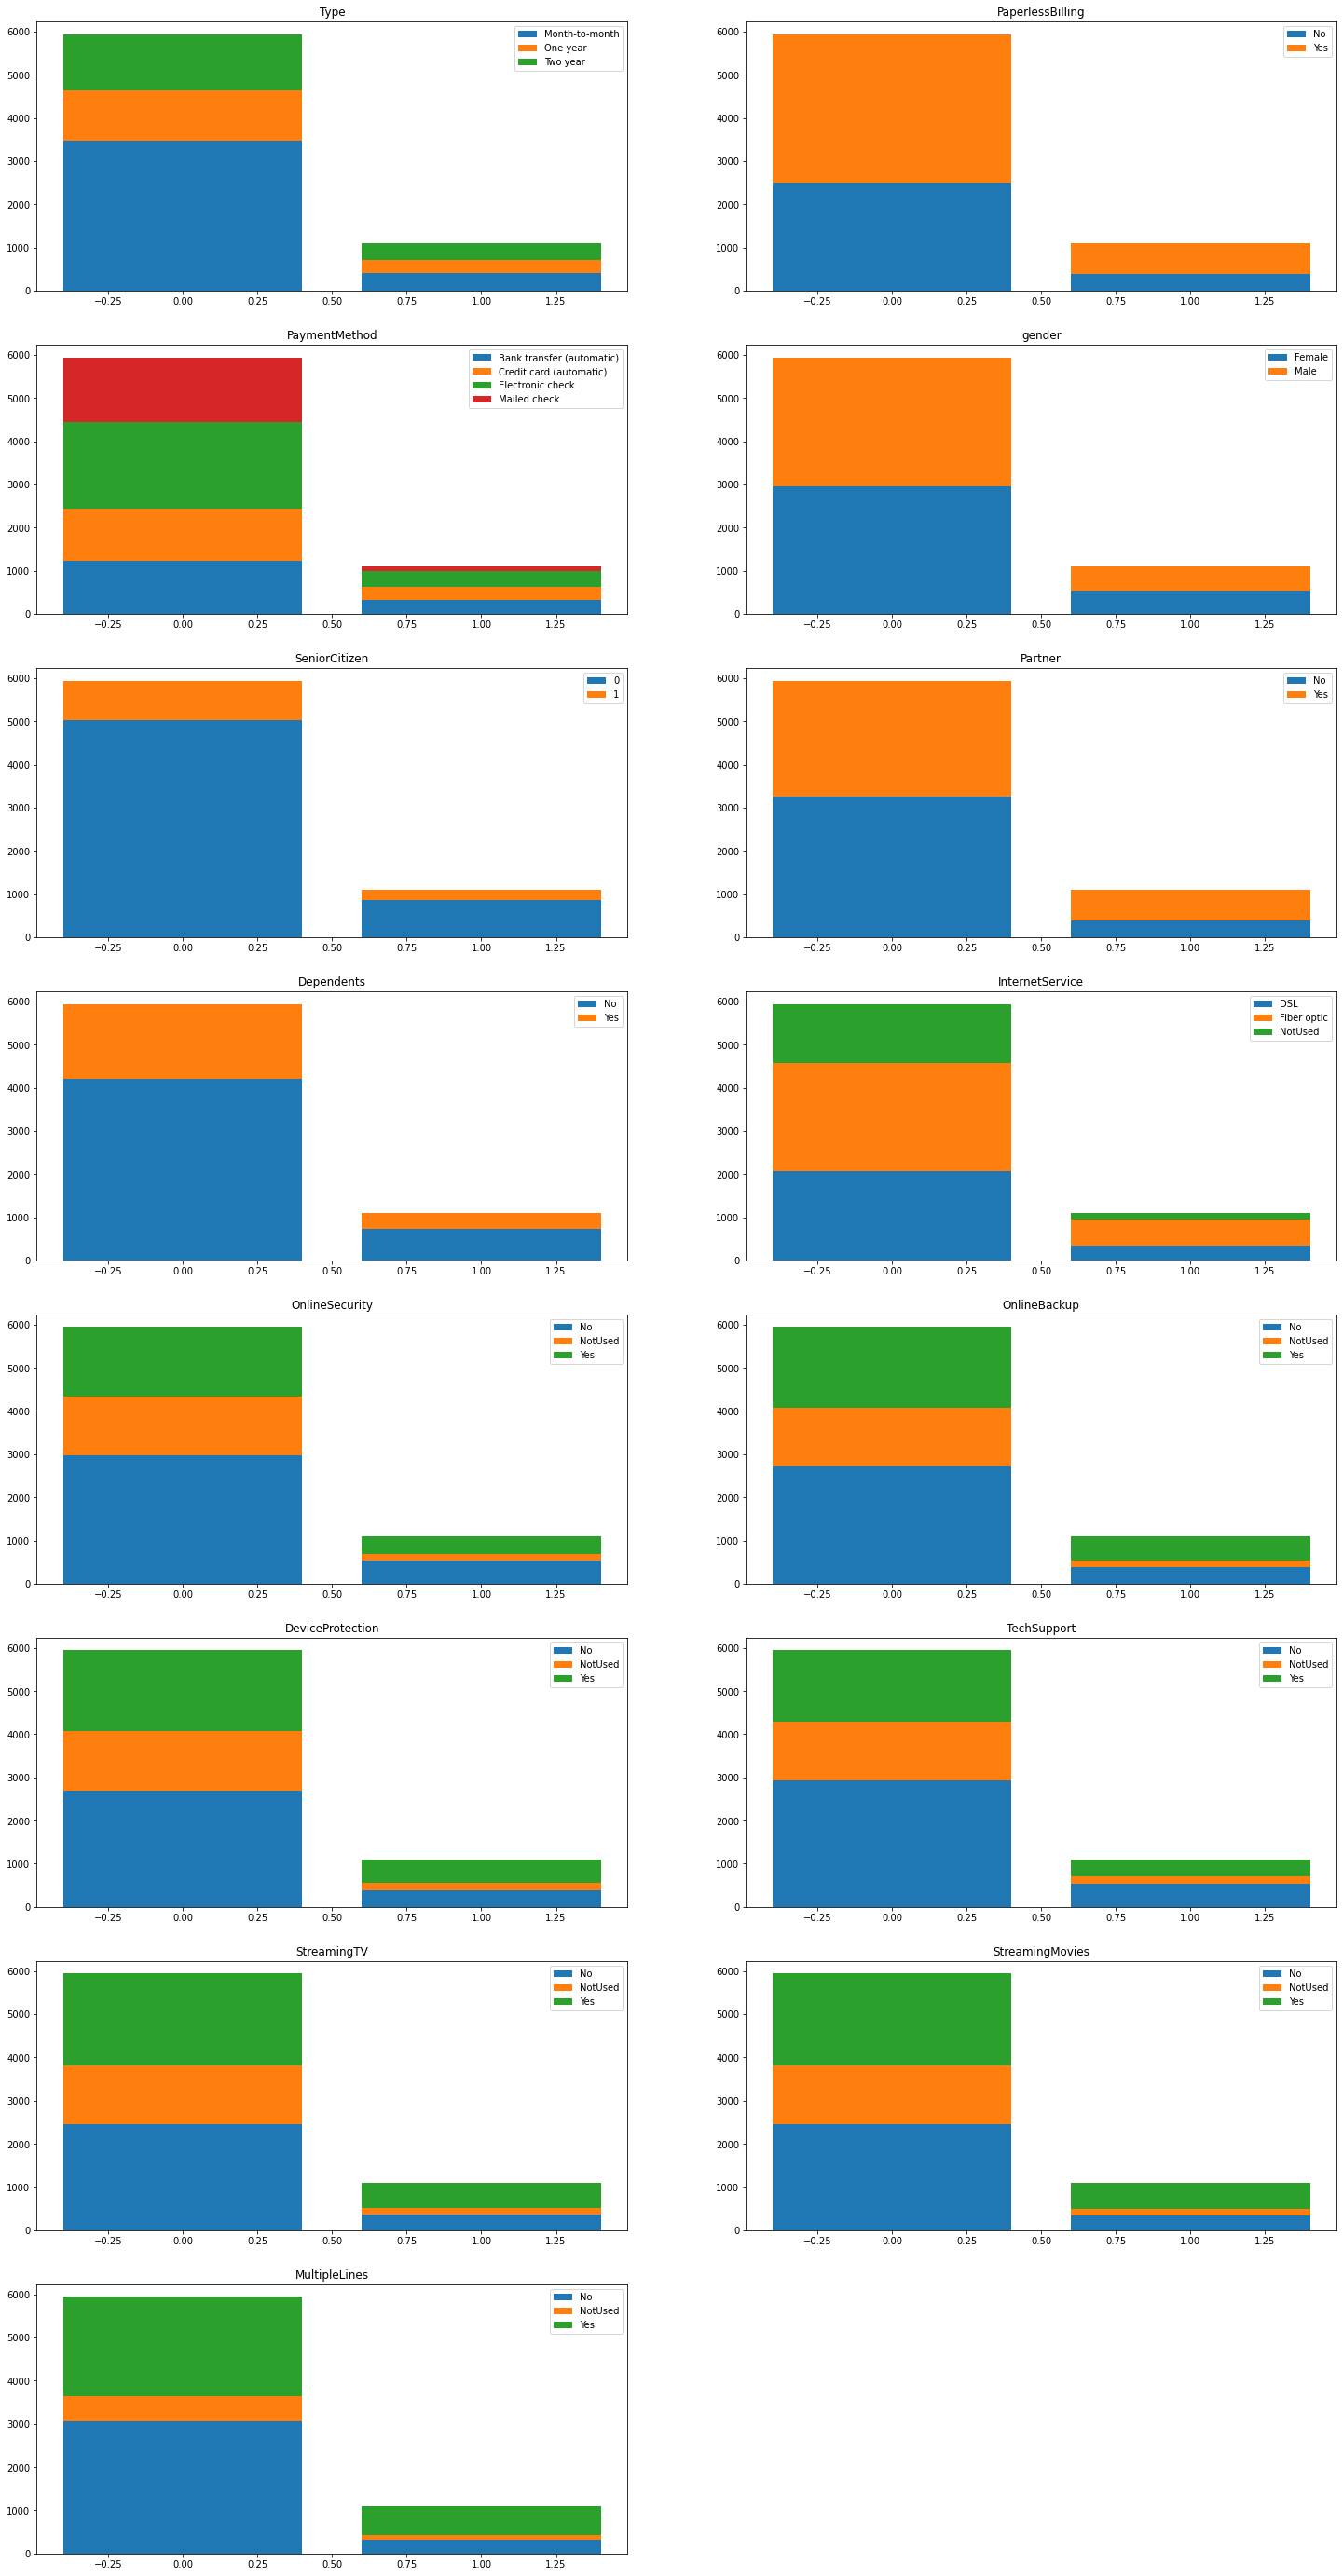

In [41]:
cols = 2
rows = int(np.ceil(len(cat_columns) / cols))

plt.figure(figsize=(25, 50))
for idx, column in enumerate(cat_columns):
    df_group = df.groupby([column, 'Fact_leave'])['Fact_leave'].count()
    df_group = df_group.unstack()
    ax = plt.subplot(rows, cols, idx+1)
    ax.bar(df_group.T.index, df_group.T[df_group.T.columns[0]], label=df_group.T.columns[0])
    bottom = np.array(df_group.T[df_group.T.columns[0]])
    for color_idx, value in enumerate(df_group.T.columns[1:]): 
        ax.bar(df_group.T.index, df_group.T[value], bottom=bottom, label=value)
        bottom += np.array(df_group.T[value])
    plt.title(column)
    plt.legend()
        
plt.show()

**Gender**: Распределения по полу идентичные. Пол не влияет на факт ухода.

**Cenior Cetizen**: Пенсионный статус не сильно влияет на факт ухода.

**Partner**: У большинства ушедших клиентов супруг/супруга есть.

**Dependents:** Наличие иждевенцев не сильно влияет на факт ухода клиентов.

**Type:** Способы оплаты у ушедших клиентов практически одинаковые. Самый популярный способ оплаты у оставшихся - помесячный;

**PaperlessBilling, PaymentMethod** Ушедшие клиенты чаще всего использовали электронные чеки и электронную оплату.


У большинства клиентов нет пенсионного статуса и иждевенцов.

**InternetService:** Оптоволокно самый распространенный способ подключения;

Дополнительные услуги **OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines** не подключены или не используются у многих клиентов.

Смотрим величину платежей ушедших и оставшихся клиентов

In [42]:
#функция для анализа
def kdeplot(data, xlabel1='', figsize1=(10, 5), label1='', suptitle1='', ylabel1='', lg='', hue1=None):
    fig, ax = plt.subplots(figsize=figsize1)
    fig.suptitle(suptitle1, fontsize=13) 
    table = sns.kdeplot(data, color='blue', alpha=.4, shade=True, label=label1, hue=hue1) 
    table.grid(color = 'grey', linewidth = 1, linestyle=':')
    table.set_xlabel(xlabel1, fontsize=10)
    table.set_ylabel(ylabel1, fontsize=10) 
    return table

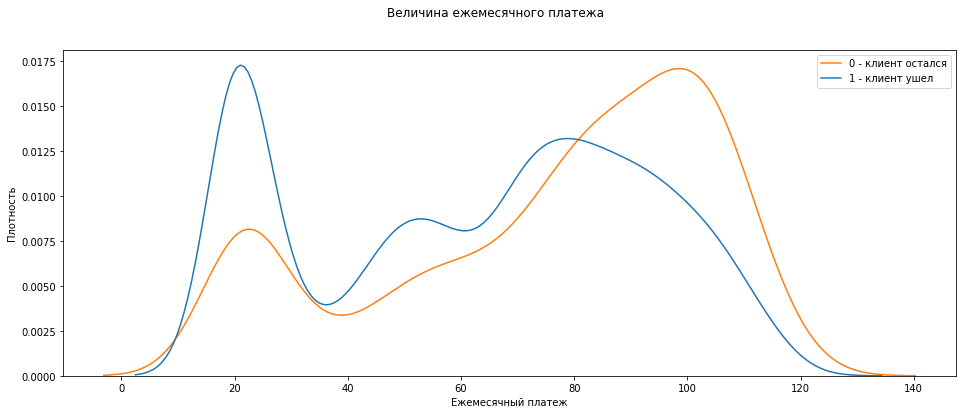

In [43]:
sns.kdeplot(data=df, x='MonthlyCharges', hue='Fact_leave', common_norm=False)

plt.xlabel('Ежемесячный платеж')
plt.ylabel('Плотность')
plt.suptitle('Величина ежемесячного платежа')
plt.legend(['0 - клиент остался', '1 - клиент ушел'])
plt.show()

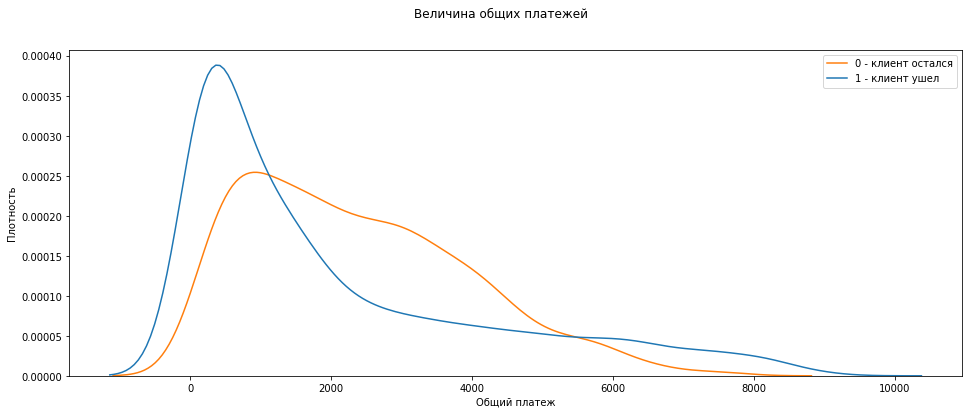

In [44]:
sns.kdeplot(data=df, x='TotalCharges', hue='Fact_leave', common_norm=False)

plt.xlabel('Общий платеж')
plt.ylabel('Плотность')
plt.suptitle('Величина общих платежей')
plt.legend(['0 - клиент остался', '1 - клиент ушел'])
plt.show()

Распределение величины ежемесячного платежа у ушедших клиетов выше. Ушедшие клиенты платили больше.

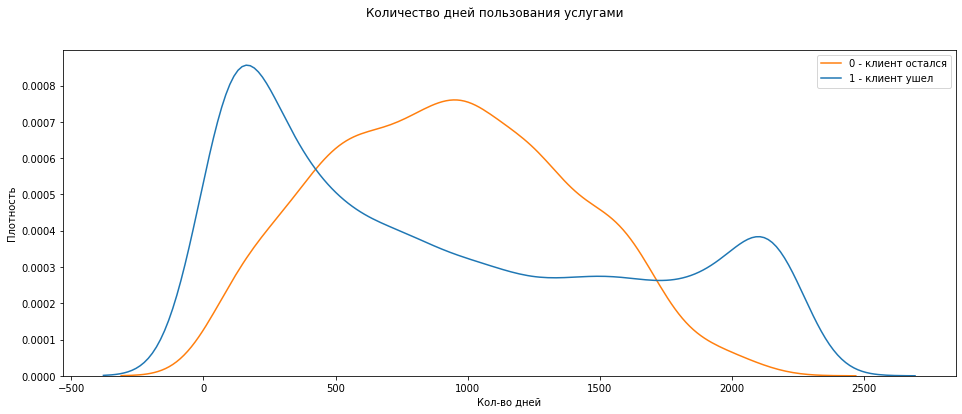

In [45]:
sns.kdeplot(data=df, x='Days', hue='Fact_leave', common_norm=False)

plt.xlabel('Кол-во дней')
plt.ylabel('Плотность')
plt.suptitle('Количество дней пользования услугами')
plt.legend(['0 - клиент остался', '1 - клиент ушел'])
plt.show()

Большинство ушедших клиентов пользовались услугами от 1 года до 3 лет

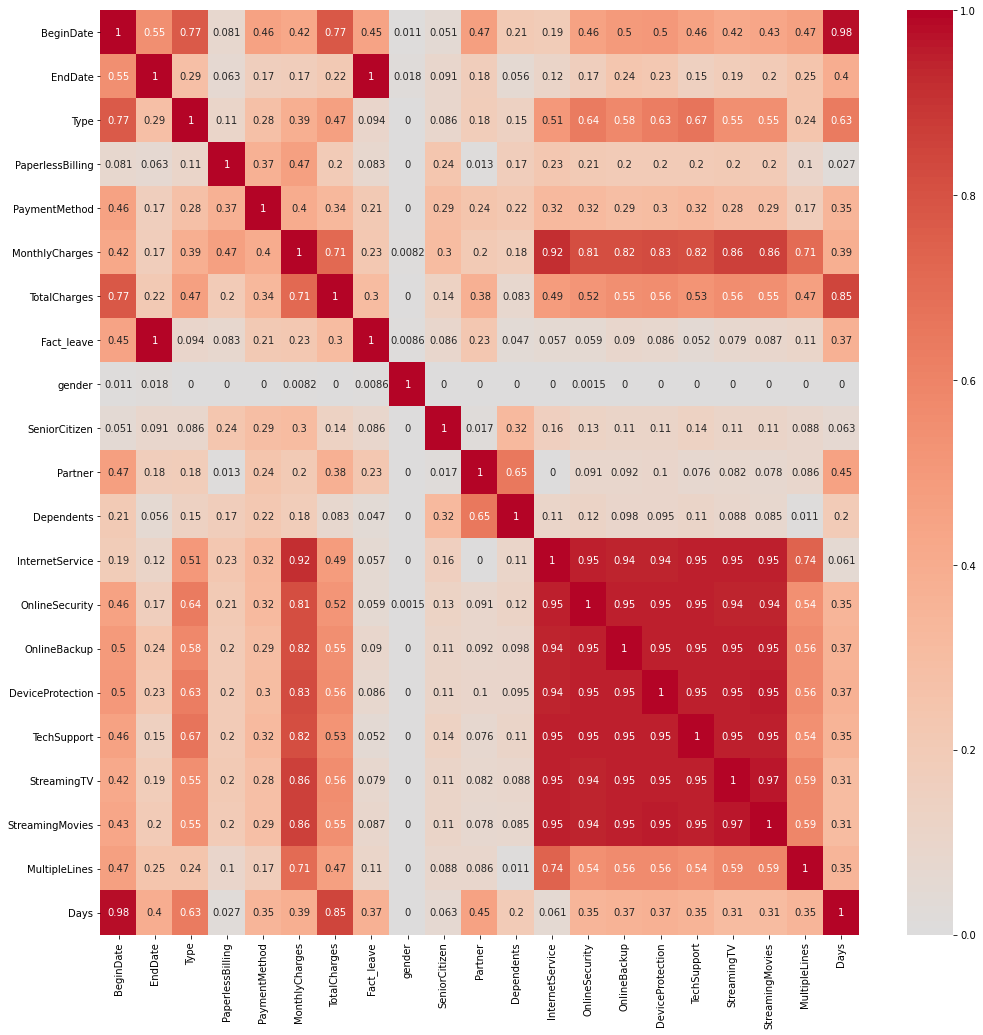

In [46]:
plt.figure(figsize=(17, 17))
sns.heatmap(df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Days']), cmap='coolwarm', center=0, annot=True);

Сильно коррелирует созданный признак Days (количество дней пользования услугами) с TotalCharges (суммарными тратами). Получается, что признаки дублируют друг друга. Так как отношение ежемесячных трат и суммарных трат и является длительностью использования услуг.

По признакам, также наблюдается корреляция признаков: т.е. если клиент не использует интернет сервис, то и услугами, которые есть в интернет сервисе он также не будет пользоваться. Аналогично и в других примерах корреляции по категориальным признакам. Информация об услугах является важным признаком, и дает понимание подключен пакет или нет.

## Обучение модели

Столбцы с датой начала пользования услугой и датой окончания пользования удалим из датасета.

In [47]:
df = df.drop(['BeginDate', 'EndDate'], axis=1)

Выделяем признаки

In [48]:
target = df['Fact_leave'] 
features = df.drop(columns=['Fact_leave'])

Делим данные на обучающую и тестовую выборки

In [49]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=.25, 
                                                                            random_state=RANDOM_STATE)

In [50]:
#проверка
train_sample = features_train.shape[0] / features.shape[0]
test_sample = features_test.shape[0] / features.shape[0]

print('Размер обучающей выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер обучающей выборки- 75%
Размер тестовой выборки - 25%


In [51]:
#выделяем категориальные признаки для модели CatBoost
cat_features = ['Type','PaperlessBilling','PaymentMethod', 
                'gender','Partner','Dependents','InternetService',
                'OnlineSecurity', 'OnlineBackup','DeviceProtection', 
                'TechSupport','StreamingTV','StreamingMovies',  
                'MultipleLines', 'SeniorCitizen']

Проводим масштабирование количественных признаков

Кодируем и маштабируем признаки с помощью OneHotEncoder

In [52]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [53]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Days']


In [54]:
features_train_ohe = features_train.copy()
features_test_ohe = features_train.copy()

In [55]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train[ohe_features])


features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[ohe_features])


features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

scaler = StandardScaler()

features_train_ohe[num_features] = scaler.fit_transform(features_train_ohe[num_features])


features_train_ohe.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,MonthlyCharges,TotalCharges,SeniorCitizen,Days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,DeviceProtection_NotUsed,DeviceProtection_Yes,TechSupport_NotUsed,TechSupport_Yes,StreamingTV_NotUsed,StreamingTV_Yes,StreamingMovies_NotUsed,StreamingMovies_Yes,MultipleLines_NotUsed,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
6087-MVHJH,0.792082,-0.205032,-0.436399,-0.469187,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1530-ZTDOZ,-0.790125,0.035458,-0.436399,0.856627,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2303-PJYHN,-1.478617,-0.976857,-0.436399,-1.222227,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
0670-ANMUU,1.096607,2.267162,-0.436399,1.832090,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
9565-DJPIB,0.830147,-0.827198,-0.436399,-1.135002,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [56]:

features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[ohe_features])

features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)


features_test_ohe[num_features] = scaler.transform(
    features_test_ohe[num_features]
)


features_test_ohe.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,Days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,DeviceProtection_NotUsed,DeviceProtection_Yes,TechSupport_NotUsed,TechSupport_Yes,StreamingTV_NotUsed,StreamingTV_Yes,StreamingMovies_NotUsed,StreamingMovies_Yes,MultipleLines_NotUsed,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
6087-MVHJH,0.792082,-0.205032,-0.436399,-0.469187,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1530-ZTDOZ,-0.790125,0.035458,-0.436399,0.856627,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2303-PJYHN,-1.478617,-0.976857,-0.436399,-1.222227,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
0670-ANMUU,1.096607,2.267162,-0.436399,1.832090,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
9565-DJPIB,0.830147,-0.827198,-0.436399,-1.135002,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [57]:
features_train_ohe.shape, features_test_ohe.shape

((5282, 29), (5282, 29))

In [87]:
# Проводим масштабирование количественных признаков для модели CatBoost
numeric = ['MonthlyCharges', 'TotalCharges', 'Days']

scaler.fit(features_train[numeric])

features_train = features_train.copy()
features_train[numeric] = scaler.transform(features_train[numeric])

features_test = features_test.copy()
features_test[numeric] = scaler.transform(features_test[numeric])

**Модель LogisticRegression**

In [74]:
%%time

model_lr = LogisticRegression(random_state=RANDOM_STATE)
params = [{'solver':['newton-cg', 'lbfgs', 'liblinear'], 'C':[0.1, 1, 10]}]

grid_lr = GridSearchCV(model_lr, params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10)
grid_lr.fit(features_train_ohe, target_train)

lr_best_params = grid_lr.best_params_
print(lr_best_params)
print('Среднее качество модели LogisticRegression на кросс-валидации:', grid_lr.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 1/3; 1/9] END ......C=0.1, solver=newton-cg;, score=0.798 total time=   0.2s
[CV 2/3; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 2/3; 1/9] END ......C=0.1, solver=newton-cg;, score=0.724 total time=   0.3s
[CV 3/3; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 3/3; 1/9] END ......C=0.1, solver=newton-cg;, score=0.772 total time=   0.3s
[CV 1/3; 2/9] START C=0.1, solver=lbfgs.........................................
[CV 1/3; 2/9] END ..........C=0.1, solver=lbfgs;, score=0.798 total time=   0.2s
[CV 2/3; 2/9] START C=0.1, solver=lbfgs.........................................
[CV 2/3; 2/9] END ..........C=0.1, solver=lbfgs;, score=0.724 total time=   0.2s
[CV 3/3; 2/9] START C=0.1, solver=lbfgs.........................................
[CV 3/3; 2/9] END ..........C=0.1, solver=lbfgs;,

**Модель CatBoostClassifier**

In [75]:
%%time

model_cat = CatBoostClassifier(verbose=False, iterations=250, random_state=RANDOM_STATE, cat_features=cat_features)
model_cat.fit(features_train, target_train)

model_cat_val = cross_val_score(model_cat, features_train, target_train, scoring='roc_auc', cv=3).mean() 
print('Среднее качество модели CatBoostClassifier на кросс-валидации:', model_cat_val)

Среднее качество модели CatBoostClassifier на кросс-валидации: 0.8513931565619051
CPU times: user 8.9 s, sys: 252 ms, total: 9.15 s
Wall time: 11.6 s


**Модель RandomForestClassifier**

In [76]:
%%time 

model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
params = [{'max_depth':[2,4,6], 'n_estimators': [10,50,100], 'class_weight':['balanced']}] 

CPU times: user 29 µs, sys: 7 µs, total: 36 µs
Wall time: 39.3 µs


In [77]:
grid_rfc = GridSearchCV(model_rfc, params, scoring='roc_auc', cv=3)
grid_rfc.fit(features_train_ohe, target_train)

rfc_best_params = grid_rfc.best_params_
print(rfc_best_params)
print('Среднее качество модели RandomForestClassifier на кросс-валидации:', grid_rfc.best_score_)

{'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 100}
Среднее качество модели RandomForestClassifier на кросс-валидации: 0.815137228299536


Сравниваем модели

In [78]:
index = ['LogisticRegression', 'RandomForestClassifier','CatBoostClassifier']
data = {'Среднее качество модели на кросс-валидации': [grid_lr.best_score_, grid_rfc.best_score_, model_cat_val]}
models_val = pd.DataFrame(data=data, index=index)
print(models_val)

                        Среднее качество модели на кросс-валидации
LogisticRegression                                        0.765939
RandomForestClassifier                                    0.815137
CatBoostClassifier                                        0.851393


Лучшая модель CatBoostClassifier с ROC-AUC score = 0,85.


Оцениваем лучшую модель на тестовой выборке

In [79]:
predict_cat = model_cat.predict(features_test)
predict_roc_auc = model_cat.predict_proba(features_test)[:,1]
print('ROC-AUC score CatBoostClassifier на тестовой выборке равна ', roc_auc_score(target_test, predict_roc_auc))
print('Accuracy CatBoostClassifier на тестовой выборке равна ', accuracy_score(target_test, predict_cat))

ROC-AUC score CatBoostClassifier на тестовой выборке равна  0.8685203116555574
Accuracy CatBoostClassifier на тестовой выборке равна  0.871663827370812


Показатель Accuracy указывает долю правильных классификаций. При значении 0,87 метрика классификационной модели демонстрирует высокую точность. Баллы выше 0,8 обычно считаются хорошим совпадением; ноль или ниже означает отсутствие согласия (практически случайные метки).

Анализ важности признаков

In [80]:
imp_fact = pd.DataFrame(model_cat.feature_importances_, index = features_test.columns, columns=['feature_importances'])
imp_fact = imp_fact.sort_values(by='feature_importances', ascending=False)
imp_fact

,feature_importances
Days,42.124629
Type,11.955052
MonthlyCharges,6.968302
TotalCharges,6.620966
MultipleLines,6.466292
PaymentMethod,5.670249
OnlineBackup,3.675913
Partner,3.491055
DeviceProtection,2.779838
OnlineSecurity,2.231318


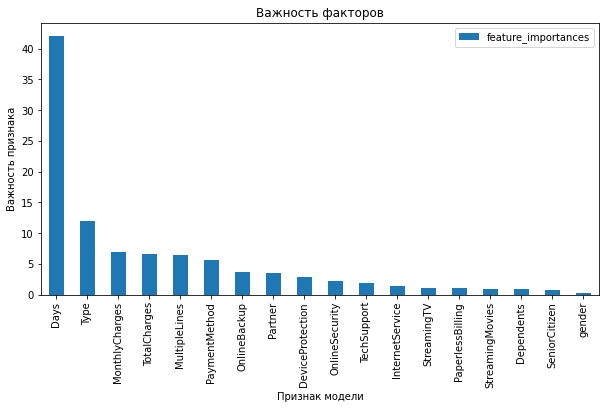

In [81]:
imp_fact.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.xlabel('Признак модели')
plt.ylabel('Важность признака')
plt.show()

Важные признаки Days, Type, TotalCharges и MonthlyCharges - количество дней пользования услугами, затраты клиентов и тип оплаты.

**Матрица ошибок**

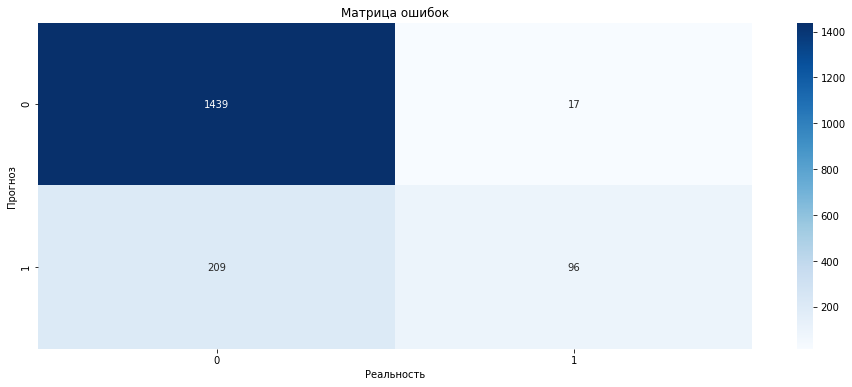

In [82]:
cm = confusion_matrix(target_test, predict_cat)
 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Реальность')
plt.ylabel('Прогноз')
plt.title('Матрица ошибок')
plt.show()

В матрице ошибок существует четыре метрики, в скобках указано количество значений, попавших в метрику:
1. Истинно-положительное решение: прогноз совпал с реальностью, результат положительный произошел, как и было предсказано ML-моделью (1439)
2. Ложноположительное решение: ошибка 1-го рода, ML-модель предсказала положительный результат, а на самом деле он отрицательный(17)
3. Ложноотрицательное решение:ошибка 2-го рода – ML-модель предсказала отрицательный результат, но на самом деле он положительный(209)
4. Истинно-отрицательное: результат отрицательный, ML-прогноз совпал с реальностью(96)

Вывод:  Благодаря представлению в виде матрицы ошибок можно оценить долю ошибочных предсказаний.
Представленная матрица ошибок демонстрирует высокую точность в выявлении каждого класса на основе нейросетевой классификационной
модели, прогноз совпал с реальностью. Доля истинно-положительных решений является достаточно высокой.

**Вывод**


Закодировали категориальные признаки с помощью One Hot Encoding

Выделили признаки и разделили данные на обучающую и тестовую выбороки

Провели масштабирование количественных признаков

Сравнили модели - лучшая модель CatBoostClassifier с ROC-AUC score на кросс-валидации = 0,85. На тестовой выборке модель показала ROC-AUC = 0,87

Анализ важности признаков показал, что Days, TotalCharges и MonthlyCharges наиболее важные признаки.


# Отчет по проекту "Телекоммуникации"

**1. Ключевые шаги**

Целью исследования было создать модель, которая на основании имеющихся даннных будет предсказывать уход клиента из компании.

Ключевые шаги работы над проектом заключались в выполнении работы по следующим этапам:

1 этап. Изучение данных. Была произведена загрузка данных (файлы CSV), изучена структура данных и основные характеристики данных.

2 этап. Предобработка данных. При предобработке данных исследуемые файлы CSV объединены в 1 файл по коду клиента("customerID") , проведена проверка на включение всех клиентов в объединенный датафрейм, обработаны пропуски, проведена кодировка категориальных признаков.

3 этап. Иследовательский анализ данных. Проведен детальный анализ, чтобы идентифицировать наиболее важные признаки, которые влияют на отток. Визуализированы данные (графическое представление данных для выявления закономерностей, корреляций и выбросов) и проведен статистический анализ.

4 этап. Моделирование и обучение модели. Проведен выбор алгоритма машинного обучения для прогнозирования оттока, данные разделены на обучающую и тестовую выборки(в соотношении 3:1), модель обучена на обучающей выборке с подбором гиперпараметров по каждому алгоритму, проведена оценка модели, оценена производительность на тестовой выборке, проведена проверка по условиям к задачи: значение основной метрики AUC-ROC>=0,85.


**2.Анализ соответствия фактической работы запланированным шагам**

Исходные данные состояли из 4 таблиц, полученных из разных источников:

- `contract_new.csv` — информация о договоре;

- `personal_new.csv` — персональные данные клиента;

- `internet_new.csv` — информация об интернет-услугах;

- `phone_new.csv` — информация об услугах телефонии.

Всего в датафрейме 7043 клиента, из которых пользователей интернета - 5517, пользователей телефона - 6361.
Определен целевой признак EndDate - длительность пользования клиентом услугами компании.

Эти данные были обработаны и на их основе смоделирована и обучена оптимальная модель, позволяющая определеоить отток клиентов. Фактическая работа полностью соответствует объему работ, запланированному к выполнению на каждом этапе, результат работы модели выше порогового значения основной метрики AUC-ROC, которое составяет 0,85.

**3.Сложности проекта**

К сложностям проекта можно отнести:
1. Предоставление исходных данных из разных источников. Все данные были объединены в одну таблицу по столбцу customerID. 
2. После соединения таблиц в данных появляются пропуски: пропуски в столбцах услуг заменили на "NotUsed", значения "No" в "EndDate" заменили на актуальную дату 01.02.2020
3. Кодирование категориальных признаков - для каждой модели использовали разные способы кодирования (OneHotEncoder, OrdinalEncoder и встроенные параментры)
4. При работе с линейной моделью исследовали корреляцию и нашли признаки, создающие мультиколлинеарность - признаки были удалены.

**4.Описание предобработки данных**

Для прогнозирования оттока клиентов добавили целевой признак факт ухода клиента: 0 - не ушел, 1 - ушел.

BeginDate и EndDate привели к формату datetime.

В EndDate заменили значения "No" на актуальную дату 01.02.2020

TotalCharges - заменили неявные пропуски и привели к числовому формату.

Объединили все данные в одну таблицу по столбцу customerID. Пропуски в столбцах услуг заменили на "NotUsed".

Добавили дополнительный столбец Days - количество дней пользования услугами.

**5.Итоговый список признаков**

Определены категориальные и количественные признаки объединенного датасета.

Категориальные признаки:
- 'Type' тип оплаты: ежемесячный, годовой и т.д.;
- 'PaperlessBilling' электронный платежный лист;
- 'PaymentMethod' тип платежа;
- 'gender' пол;
- 'Partner' есть ли у абонента супруг или супруга;
- 'Dependents' есть ли у абонента дети;
- 'InternetService' тип подключения;
- 'OnlineSecurity' блокировка опасных сайтов;
- 'OnlineBackup' облачное хранилище файлов для резервного копирования данных;
- 'DeviceProtection' антивирус;
- 'TechSupport' выделенная линия технической поддержки;
- 'StreamingTV' стриминговое телевидение;
- 'StreamingMovies' каталог фильмов;
- 'MultipleLines' подключение телефона к нескольким линиям одновременно;
Количественные признаки:
- 'MonthlyCharges' расходы за месяц;
- 'TotalCharges' общие расходы абонента;
- 'Days' количество дней пользования услугами;

Анализ признаков определяет следующие закономерности:

- Gender: Распределения по полу идентичные. Пол не влияет на факт ухода.

- Cenior Cetizen: Пенсионный статус не сильно влияет на факт ухода.

- Partner: У большинства ушедших клиентов супруг/супруга есть.

- Dependents: Наличие иждевенцев не сильно влияет на факт ухода клиентов.

- Type: Способы оплаты у ушедших клиентов практически одинаковые. Самый популярный способ оплаты у оставшихся - помесячный;

- PaperlessBilling, PaymentMethod Ушедшие клиенты чаще всего использовали электронные чеки и электронную оплату.

- У большинства клиентов нет пенсионного статуса и иждевенцов.

- InternetService: Оптоволокно самый распространенный способ подключения;

- Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не подключены или не используются у многих клиентов.

Проанализированы непрерывные признаки в разрезе оттока:

- Распределение величины ежемесячного платежа у ушедших клиетов выше. Ушедшие клиенты платили больше.

- Большинство ушедших клиентов пользовалиьс услугами от 1 года до 3 лет



**6.Сводная таблица исследованных моделей**

In [83]:
index = ['LogisticRegression', 'RandomForestClassifier','CatBoostClassifier']
data = {'Среднее качество модели на кросс-валидации': [grid_lr.best_score_, grid_rfc.best_score_, model_cat_val]}
models_val = pd.DataFrame(data=data, index=index)
print(models_val)

                        Среднее качество модели на кросс-валидации
LogisticRegression                                        0.765939
RandomForestClassifier                                    0.815137
CatBoostClassifier                                        0.851393


Среднее качество модели на кросс-валидации показывает среднюю точность модели на  кросс-валидации. Кросс-валидация представляет собой метод, который позволяет оценить производительность модели на нескольких подмножествах данных. Среднее качество модели на кросс-валидации является обобщающей метрикой, которая учитывает предсказательную способность модели. Чем выше значение среднего качества, тем лучше модель обобщает данные и лучше способна делать предсказания на новых наборах данных.

При сравнении с другими моделями, CatBoostClassifier показывает самый высокий показатель среднего качества.

**7.Лучшая модель**

Лучшая модель CatBoostClassifier с ROC-AUC score = 0,85.
При метрике ROC-AUC score = 0,85 модель хорошо разделяет классы и имеет хорошую предсказательную способность.

**8.Итоговая метрика на test**

* ROC-AUC score CatBoostClassifier на тестовой выборке равна  0.8685203116555574
* Accuracy CatBoostClassifier на тестовой выборке равна  0.871663827370812

Показатель Accuracy указывает долю правильных классификаций. При значении 0,87 метрика классификационной модели демонстрирует высокую точность. Баллы выше 0,8 обычно считаются хорошим совпадением; ноль или ниже означает отсутствие согласия (практически случайные метки)

**9.Важность признаков**

Анализ важности признаков помогает понять, какие признаки имеют наибольший вклад в модель и могут быть использованы для улучшения предсказаний. Это может быть полезно для отбора наиболее информативных признаков, улучшения интерпретируемости модели и оптимизации производительности модели.

In [84]:
imp_fact = pd.DataFrame(model_cat.feature_importances_, index = features_test.columns, columns=['feature_importances'])
imp_fact = imp_fact.sort_values(by='feature_importances', ascending=False)
imp_fact

,feature_importances
Days,42.124629
Type,11.955052
MonthlyCharges,6.968302
TotalCharges,6.620966
MultipleLines,6.466292
PaymentMethod,5.670249
OnlineBackup,3.675913
Partner,3.491055
DeviceProtection,2.779838
OnlineSecurity,2.231318


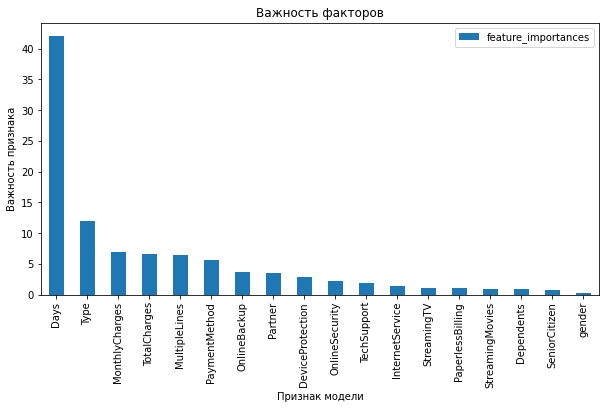

In [85]:
imp_fact.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.xlabel('Признак модели')
plt.ylabel('Важность признака')
plt.show()

Важные признаки Days, Type, TotalCharges и MonthlyCharges - количество дней пользования услугами, затраты клиентов и тип оплаты.

**Матрица ошибок**

В матрице ошибок существует четыре метрики, в скобках указано количество значений, попавших в метрику:
1. Истинно-положительное решение: прогноз совпал с реальностью, результат положительный произошел, как и было предсказано ML-моделью (1439)
2. Ложноположительное решение: ошибка 1-го рода, ML-модель предсказала положительный результат, а на самом деле он отрицательный(17)
3. Ложноотрицательное решение:ошибка 2-го рода – ML-модель предсказала отрицательный результат, но на самом деле он положительный(209)
4. Истинно-отрицательное: результат отрицательный, ML-прогноз совпал с реальностью(96)

Вывод:  Благодаря представлению в виде матрицы ошибок можно оценить долю ошибочных предсказаний.
Представленная матрица ошибок демонстрирует высокую точность в выявлении каждого класса на основе нейросетевой классификационной
модели, прогноз совпал с реальностью. Доля истинно-положительных решений является достаточно высокой.

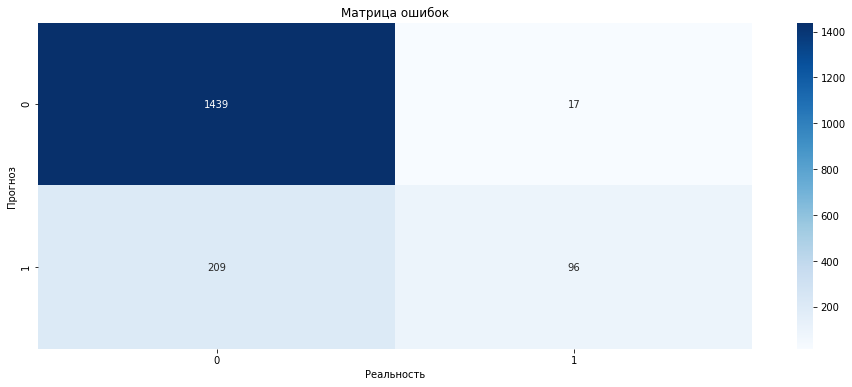

In [86]:
cm = confusion_matrix(target_test, predict_cat)
 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Реальность')
plt.ylabel('Прогноз')
plt.title('Матрица ошибок')
plt.show()